_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 20)      560       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 20)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100, 20)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 98, 98, 40)        7240      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 40)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96040)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               49172992  
__________

Text(0.5,1,'Accuracy Curves')

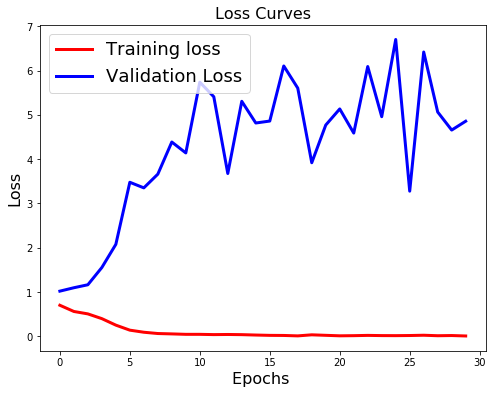

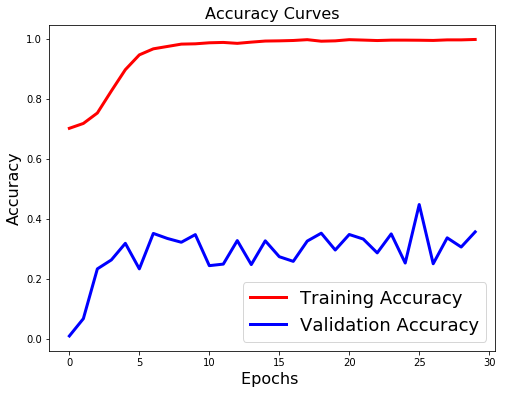

In [3]:
import numpy as np
from PIL import Image
from pylab import save,load
# Parameters
seed = 7
np.random.seed(seed)


### Load Data

target_image_size = 200
n_train=-1#1000
n_test=-1#200


data_folder="./data/"

train_image_paths = data_folder  + "MURA-v1.1/train_image_paths.csv"
train_labeled_studies = data_folder + "MURA-v1.1/train_labeled_studies.csv"
valid_image_paths = data_folder  + "MURA-v1.1/valid_image_paths.csv"
valid_labeled_studies = data_folder + "MURA-v1.1/valid_labeled_studies.csv"

bone_name="XR_SHOULDER" # or ALL
reload = True

def read_image(path):
    old_image=Image.open(path)
    old_image=old_image.convert("RGB")
    old_max_size=max(old_image.size[0],old_image.size[1])
    
    new_image=Image.new("RGB",(old_max_size,old_max_size))
    left_margin = abs(old_max_size-old_image.size[0])//2
    top_margin = abs(old_max_size-old_image.size[1])//2
    
    new_image.paste(old_image,(left_margin,top_margin))
    new_image=new_image.resize((target_image_size,target_image_size))
    new_image=np.array(new_image)
    new_image=np.round(new_image/255,4)
    return new_image

def read_data(x_path,y_path,max_num=-1,bone_name="all"):
    i=0
    x=[]
    y=[]
    # Map: key:Image path, value: output 0/1
    labels=open(y_path).readlines()
    labels=[l.split(",") for l in labels]
    labels={l[0]:int(l[1][0:1]) for l in labels}
    
    input_file=open(x_path)
    for line in input_file:
        if bone_name.lower() =="all" or (bone_name in line):
            image_path=data_folder+ line[0:len(line)-1]
            image=read_image(image_path)
            x.append(image)
            l =labels[line[0:line.rfind("/")+1]]
            y.append(l)
            i+=1
            if (max_num > 0 and i>= max_num):
                break;
    return np.array(x),np.array(y)

if (reload):
    # Train set
    x_train,y_train = read_data(train_image_paths,train_labeled_studies, n_train, bone_name)
    # Test set
    x_test,y_test = read_data(valid_image_paths,valid_labeled_studies, n_test, bone_name)
  
    save(data_folder + "x_train_" + bone_name, x_train)
    save(data_folder + "y_train_"+ bone_name, y_train)
    save(data_folder + "x_test_"+ bone_name, x_test)
    save(data_folder + "y_test_"+ bone_name, y_test)
else:
    # Load saved data
    x_train = load(data_folder + "x_train_" + bone_name + ".npy")
    y_train = load(data_folder + "y_train_" + bone_name + ".npy")
    x_test = load(data_folder + "x_test_" + bone_name + ".npy")
    y_test = load(data_folder + "y_test_" + bone_name + ".npy")




### Build the model:

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization,Activation,InputLayer

# Parameters
kernel_size=3
conv_kernels_1=20
conv_kernels_2=40
drop_prop_1=0.25
drop_prop_2=0.5

pool_size=2
dense_size=512

epochs=30
batch_size=32
n_classes = 1

n_train, height, width, depth = x_train.shape
n_test = x_test.shape[0]

input_shape=(height,width,depth)


def create_cnn_model(): 
    cnn = Sequential()
    
    cnn.add(Conv2D(conv_kernels_1, (kernel_size, kernel_size), padding="same",input_shape=input_shape, activation="relu"))
    cnn.add(MaxPooling2D((pool_size,pool_size)))
    cnn.add(Dropout(drop_prop_1))
    
    cnn.add(Conv2D(conv_kernels_2, (kernel_size, kernel_size), activation="relu"))
    cnn.add(MaxPooling2D((pool_size,pool_size)))
    
    cnn.add(Flatten())
    
    cnn.add(Dense(dense_size, kernel_initializer='normal', activation='relu'))
    cnn.add(Dense(dense_size//2, kernel_initializer='normal', activation='relu'))
    cnn.add(Dense(n_classes,activation='sigmoid'))
    
    # Compile model
    cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

# Create a model
model=create_cnn_model()
# Print the model summary
model.summary()

history = model.fit(x_train, y_train, validation_split=0.30, batch_size=batch_size, epochs=epochs, verbose=2)

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print ('test_loss:%2.2f,test_accuracy:%2.2f' % (test_loss,test_accuracy)) #85%

#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
